This gives satisfactory result on videos taken by ANPR HD camera <br>
Example download and run the code on this video:
https://www.youtube.com/watch?v=8UaAxpK0yxg

In [8]:
import cv2
import numpy as np
from skimage.filters import threshold_local
import tensorflow as tf
from skimage import measure
import imutils
import matplotlib.pyplot as plt
import traceback
import matplotlib.pyplot as plt
import copy

print(cv2.__version__)
print(np.__version__)
print(imutils.__version__)


3.4.2
1.17.1
0.5.3


In [10]:
import cv2
import numpy as np
from skimage.filters import threshold_local
import tensorflow as tf
from skimage import measure
import imutils
import copy

def sort_cont(character_contours):
    """
    To sort contours
    """
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in character_contours]
      
    (character_contours, boundingBoxes) = zip(*sorted(zip(character_contours,
                                                          boundingBoxes),
                                                          key = lambda b: b[1][i],
                                                          reverse = False))
    return character_contours
  

def segment_chars(plate_img, fixed_width):
      
    """
    extract Value channel from the HSV format
    of image and apply adaptive thresholding
    to reveal the characters on the license plate
    """
    value = cv2.split(cv2.cvtColor(plate_img, cv2.COLOR_BGR2HSV))[2]
  
    thresh = cv2.adaptiveThreshold(value, 255, 
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 
                                   11, 2)
  
    thresh = cv2.bitwise_not(thresh)
  
    # resize the license plate region to
    # a canoncial size
    plate_img = imutils.resize(plate_img, width = fixed_width)
    thresh = imutils.resize(thresh, width = fixed_width)
    bgr_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
  
    # perform a connected components analysis 
    # and initialize the mask to store the locations
    # of the character candidates
    labels = measure.label(thresh, neighbors = 8, background = 0)
  
    charCandidates = np.zeros(thresh.shape, dtype ='uint8')
  
    # loop over the unique components
    characters = []
    for label in np.unique(labels):
          
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask to display
        # only connected components for the current label,
        # then find contours in the label mask
        labelMask = np.zeros(thresh.shape, dtype ='uint8')
        labelMask[labels == label] = 255
  
        cnts = cv2.findContours(labelMask, 
                     cv2.RETR_EXTERNAL, 
                     cv2.CHAIN_APPROX_SIMPLE)
  
        cnts = cnts[0] if imutils.is_cv2() else cnts[1]
  
        # ensure at least one contour was found in the mask
        if len(cnts) > 0:
  
            # grab the largest contour which corresponds 
            # to the component in the mask, then grab the
            # bounding box for the contour
            c = max(cnts, key = cv2.contourArea)
            (boxX, boxY, boxW, boxH) = cv2.boundingRect(c)
  
            # compute the aspect ratio, solodity, and 
            # height ration for the component
            aspectRatio = boxW / float(boxH)
            solidity = cv2.contourArea(c) / float(boxW * boxH)
            heightRatio = boxH / float(plate_img.shape[0])
  
            # determine if the aspect ratio, solidity, 
            # and height of the contour pass the rules
            # tests

            keepAspectRatio = aspectRatio < 1.0
            keepSolidity = solidity > 0.15
            keepHeight = heightRatio > 0.5 and heightRatio < 0.95
  
            # check to see if the component passes
            # all the tests
            if keepAspectRatio and keepSolidity and keepHeight and boxW > 14:
                  
                # compute the convex hull of the contour
                # and draw it on the character candidates
                # mask
                hull = cv2.convexHull(c)
  
                cv2.drawContours(charCandidates, [hull], -1, 255, -1)
  
    _, contours, hier = cv2.findContours(charCandidates,
                                         cv2.RETR_EXTERNAL,
                                         cv2.CHAIN_APPROX_SIMPLE)
      
    if contours:
        contours = sort_cont(contours)
          
        # value to be added to each dimension 
        # of the character
        addPixel = 4  
        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)
            if y > addPixel:
                y = y - addPixel
            else:
                y = 0
            if x > addPixel:
                x = x - addPixel
            else:
                x = 0
            temp = bgr_thresh[y:y + h + (addPixel * 2),
                              x:x + w + (addPixel * 2)]
  
            characters.append(temp)
              
        return characters
      
    else:
        return None



class PlateFinder:
    def __init__(self):
          
        # minimum area of the plate
        self.min_area = 2500  
          
        # maximum area of the plate
        self.max_area = 45000  
        
        self.element_structure = cv2.getStructuringElement(shape = cv2.MORPH_RECT, ksize =(22, 3))
    
    
    def preprocess(self, input_img):
          
        imgBlurred = cv2.GaussianBlur(input_img, (5, 5), 0)
        
        # convert to gray
        gray = cv2.cvtColor(imgBlurred, cv2.COLOR_BGR2GRAY) 
          
        # sobelX to get the vertical edges
        sobelx = cv2.Sobel(gray, cv2.CV_8U, 1, 0, ksize = 3)  
          
        # otsu's thresholding
        ret2, threshold_img = cv2.threshold(sobelx, 0, 255,
                         cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
  
        element = self.element_structure
        morph_n_thresholded_img = threshold_img.copy()
        cv2.morphologyEx(src = threshold_img, 
                         op = cv2.MORPH_CLOSE,
                         kernel = element,
                         dst = morph_n_thresholded_img)
          
        return morph_n_thresholded_img


    def extract_contours(self, after_preprocess):
          
        _, contours, _ = cv2.findContours(after_preprocess, 
                                          mode = cv2.RETR_EXTERNAL,
                                          method = cv2.CHAIN_APPROX_NONE)
        return contours


    def clean_plate(self, plate):
          
        gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray,
                                       255, 
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY,
                                       11, 2)
          
        _, contours, _ = cv2.findContours(thresh.copy(), 
                                          cv2.RETR_EXTERNAL,
                                          cv2.CHAIN_APPROX_NONE)
  
        if contours:
            areas = [cv2.contourArea(c) for c in contours]
              
            # index of the largest contour in the area
            # array
            max_index = np.argmax(areas)  
  
            max_cnt = contours[max_index]
            max_cntArea = areas[max_index]
            x, y, w, h = cv2.boundingRect(max_cnt)
            rect = cv2.minAreaRect(max_cnt)
            
            if not self.ratioCheck(max_cntArea, plate.shape[1], plate.shape[0]):
                return plate, False, None
              
            return plate, True, [x, y, w, h]
          
        else:
            return plate, False, None



    def check_plate(self, input_img, contour):
        
        min_rect = cv2.minAreaRect(contour)
        
        if self.validateRatio(min_rect):
            x, y, w, h = cv2.boundingRect(contour)
            after_validation_img = input_img[y:y + h, x:x + w]
             
            after_clean_plate_img, plateFound, coordinates = self.clean_plate(after_validation_img)
              
            if plateFound:
                characters_on_plate = self.find_characters_on_plate(after_clean_plate_img)
                  
                if (characters_on_plate is not None and len(characters_on_plate) <= 10 
                    and len(characters_on_plate) >= 6):
                    
                    x1, y1, w1, h1 = coordinates
                    coordinates = x1 + x, y1 + y
                    after_check_plate_img = after_clean_plate_img
                      
                    return after_check_plate_img, characters_on_plate, coordinates
          
        return None, None, None



    def find_possible_plates(self, input_img):
          
        """
        Finding all possible contours that can be plates
        """
        plates = []
        self.char_on_plate = []
        self.corresponding_area = []

        self.after_preprocess = self.preprocess(input_img)
        possible_plate_contours = self.extract_contours(self.after_preprocess)
        
#         img2 = copy.deepcopy(input_img)
#         final_image = cv2.drawContours(img2, possible_plate_contours, -1, (0, 255, 0), 2)
#         plt.imshow(final_image)
#         plt.show()
        
        for cnts in possible_plate_contours:
            plate, characters_on_plate, coordinates = self.check_plate(input_img, cnts)
              
            if plate is not None:
                plates.append(plate)
                self.char_on_plate.append(characters_on_plate)
                self.corresponding_area.append(coordinates)
  
        if (len(plates) > 0):
            return plates
          
        else:
            return None


    def find_characters_on_plate(self, plate):
  
        charactersFound = segment_chars(plate, 400)
        if charactersFound:
            return charactersFound
  

    # PLATE FEATURES
    def ratioCheck(self, area, width, height):
          
        min = self.min_area
        max = self.max_area
  
        ratioMin = 3
        ratioMax = 6
  
        ratio = float(width) / float(height)
          
        if ratio < 1:
            ratio = 1 / ratio
        
        if (area < min or area > max) or (ratio < ratioMin or ratio > ratioMax):
            return False

        return True
  

    def preRatioCheck(self, area, width, height):
          
        min = self.min_area
        max = self.max_area
  
        ratioMin = 2.5
        ratioMax = 7
  
        ratio = float(width) / float(height)
          
        if ratio < 1:
            ratio = 1 / ratio
  
        if (area < min or area > max) or (ratio < ratioMin or ratio > ratioMax):
            return False
          
        return True
  

    def validateRatio(self, rect):
        (x, y), (width, height), rect_angle = rect
  
        if (width > height):
            angle = -rect_angle
        else:
            angle = 90 + rect_angle
  
        if angle > 15:
            return False
          
        if (height == 0 or width == 0):
            return False
  
        area = width * height
          
        if not self.preRatioCheck(area, width, height):
            return False
        else:
            return True
        


c:\users\jai\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2


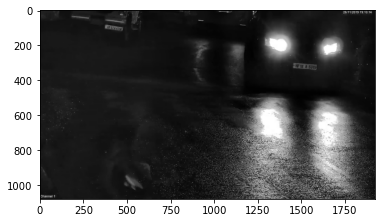

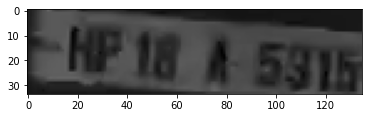

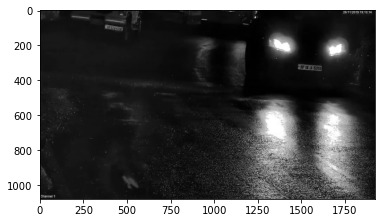

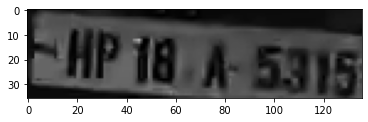

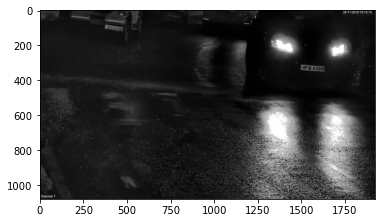

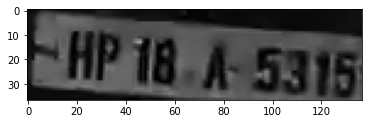

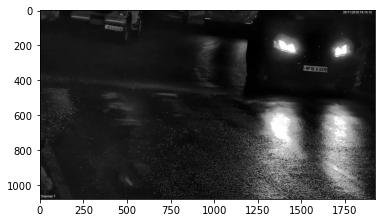

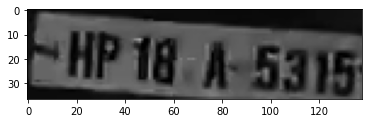

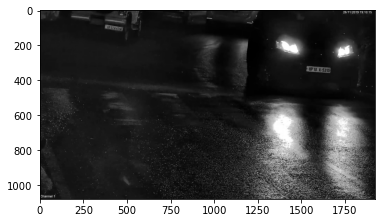

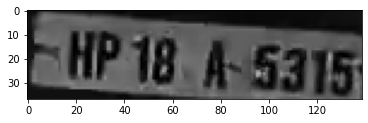

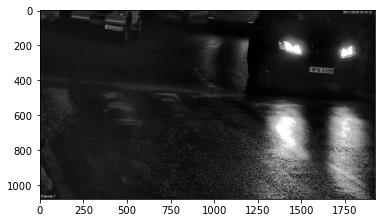

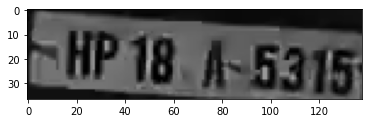

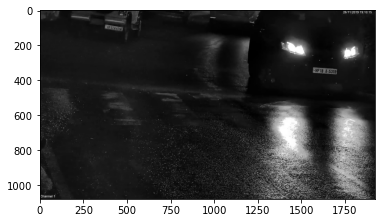

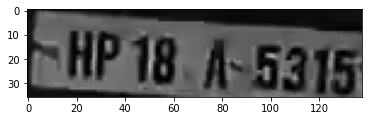

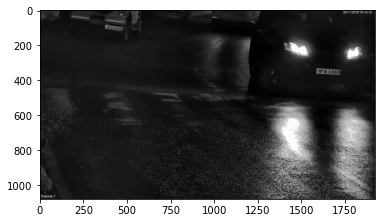

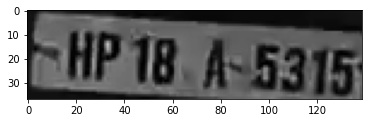

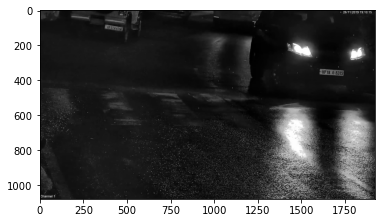

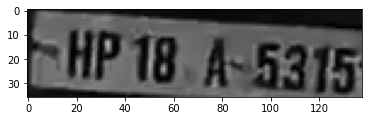

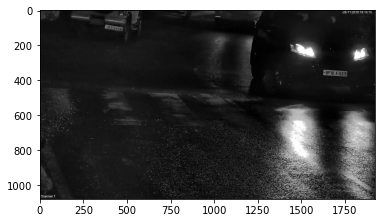

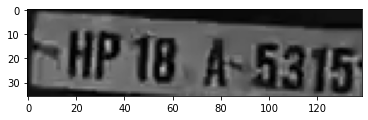

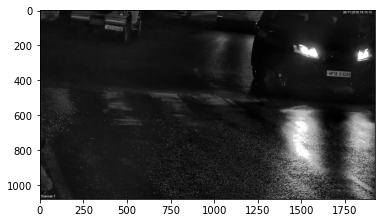

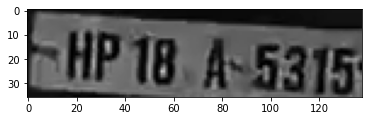

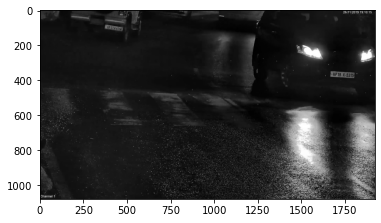

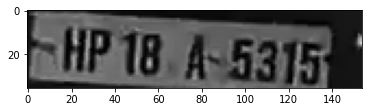

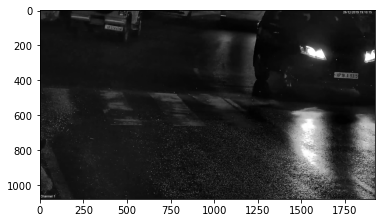

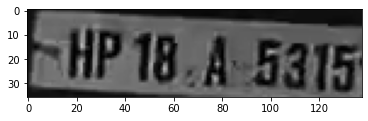

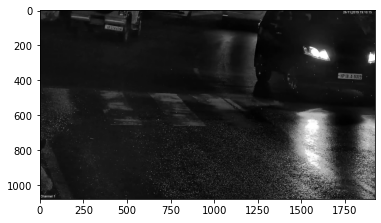

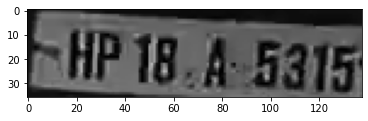

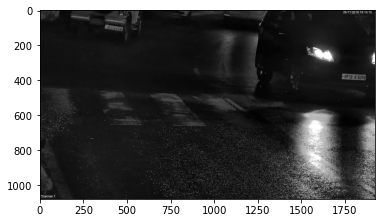

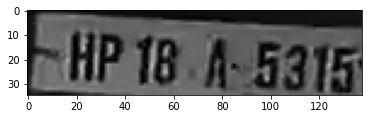

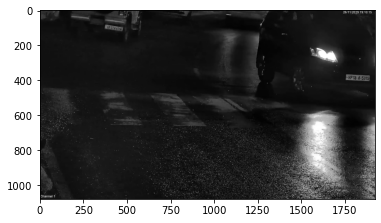

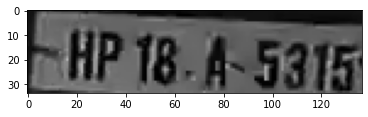

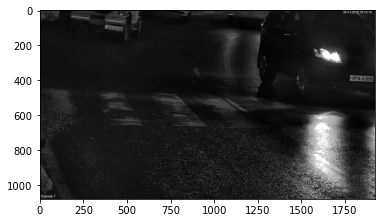

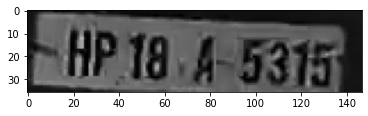

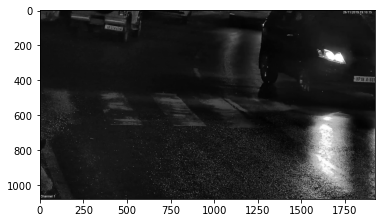

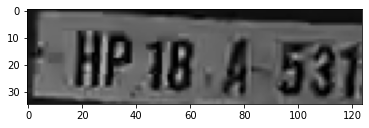

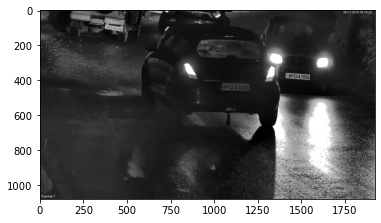

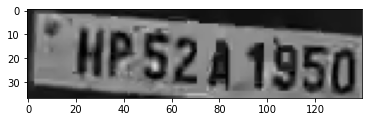

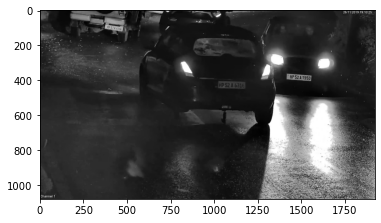

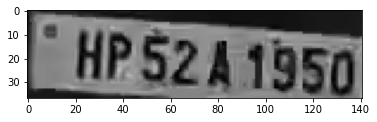

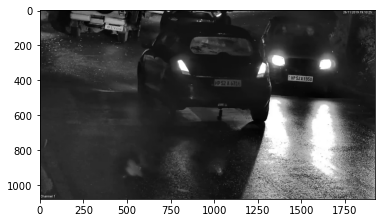

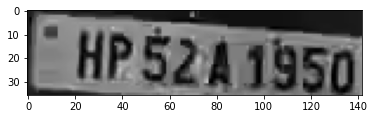

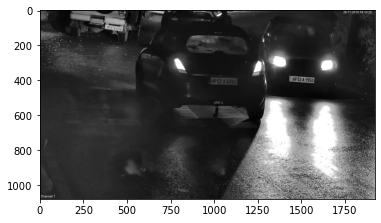

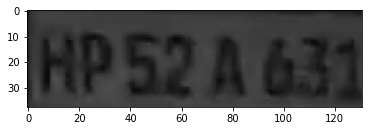

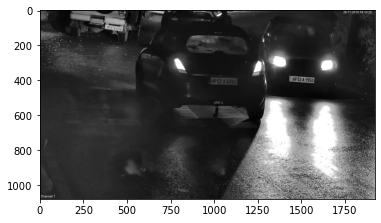

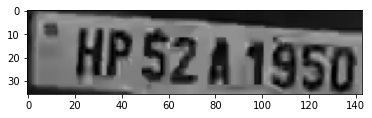

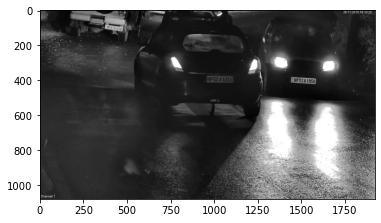

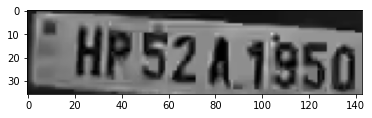

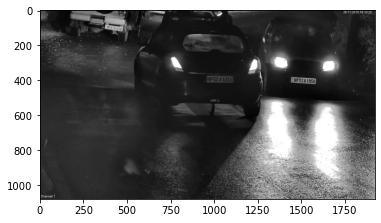

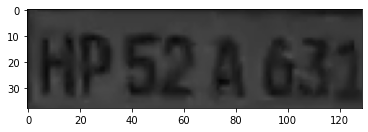

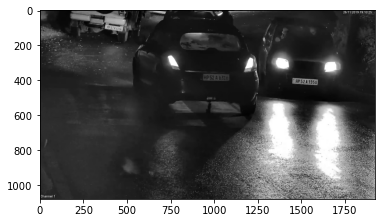

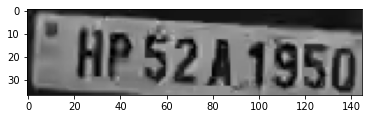

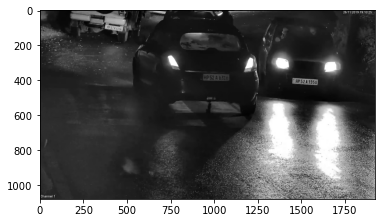

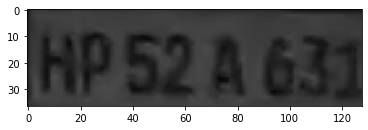

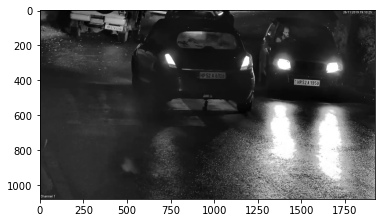

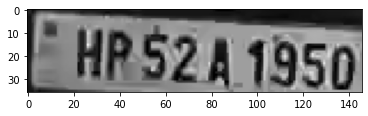

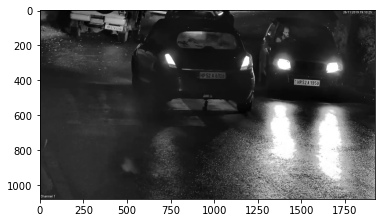

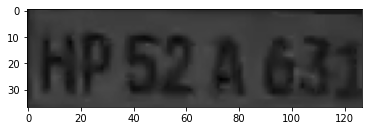

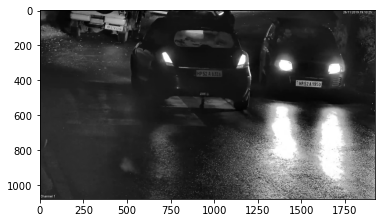

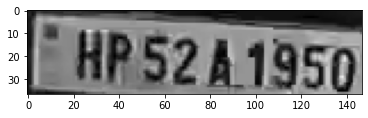

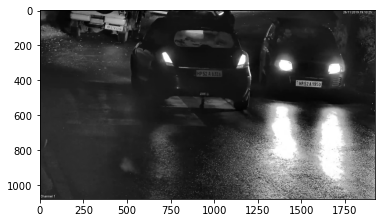

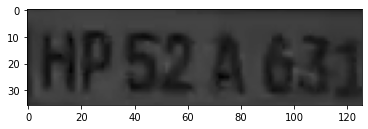

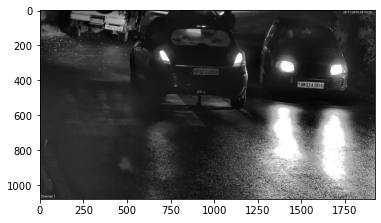

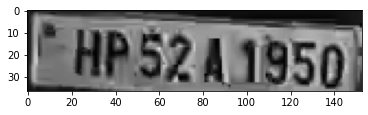

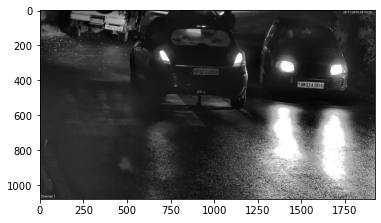

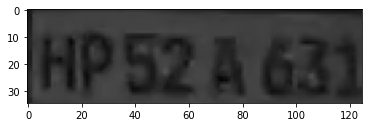

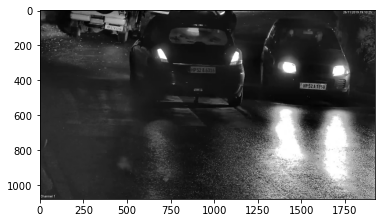

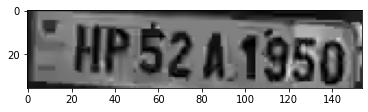

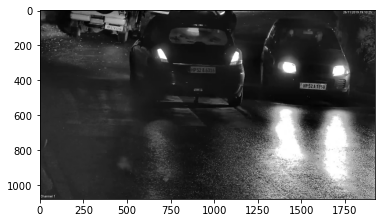

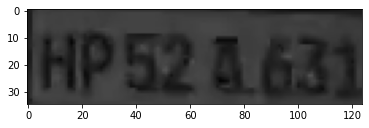

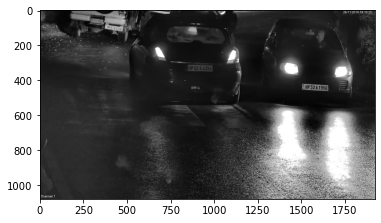

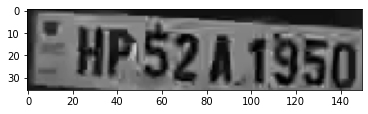

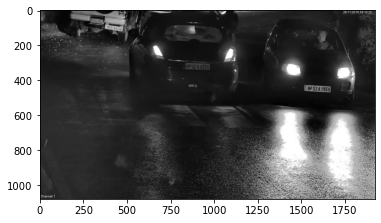

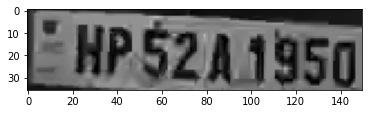

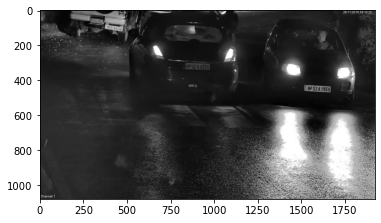

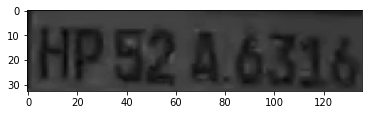

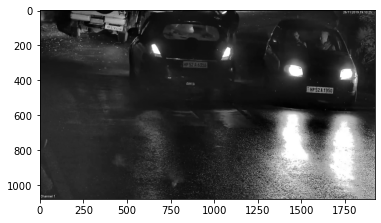

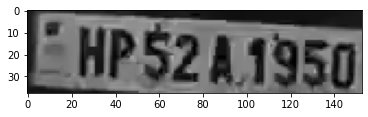

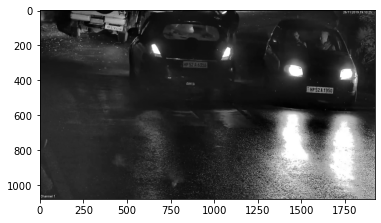

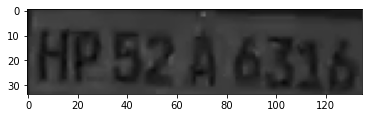

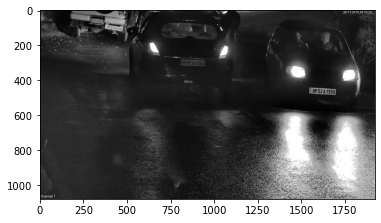

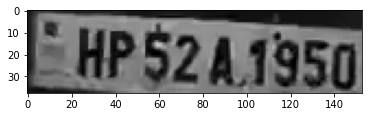

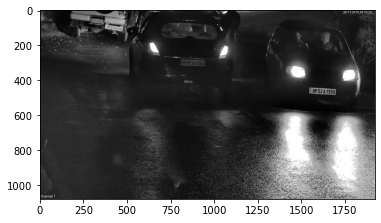

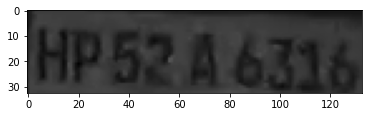

In [11]:
# videoplayback.webm

if __name__ == "__main__":
      
    findPlate = PlateFinder()
    cap = cv2.VideoCapture('D:/A_Shifted_From_C_Drive/zzzz_code_testing/Pattern_Recognition/NPR_PR_Project_Testing/videoplayback.mp4')       # ANPR camera blacked the best !! hit

    cnt=0 
    limit=0
    while (cap.isOpened()):
        ret, img = cap.read()
        
        if cnt<limit:
            cnt+=1
            continue
            
        if cv2.waitKey(10) & 0xFF == ord('f'):
            limit+=20
        
        if ret == True:
              
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
              
            possible_plates = findPlate.find_possible_plates(img)
            
            imS = cv2.resize(img, (960, 540))
            cv2.imshow('original video', imS)
            
            if possible_plates is not None:
                  
                for i, p in enumerate(possible_plates):
                    plt.imshow(img)
                    plt.show()
                    cv2.imshow('plate', p)
                    plt.imshow(p)
                    plt.show()
                      
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break
        else:
            break
              
    cap.release()
    cv2.destroyAllWindows()